# 自作ガウシアン

In [164]:
def gauss(x, a, mu, si):
    """
    a: 最大値
    mu: 位置
    si: 線幅
    noisef: 最低値
    """
    return a * np.exp(-(x - mu)**2 / 2 / si**2)

In [165]:
f = lambda x, a, mu, si, nf: gauss(x, a, mu, si) + nf 

In [166]:
nf=0.5
n=1001
x = np.linspace(0,100,n)
a, mu, si = 1, 50, 1

In [167]:
g= f(x, a, mu, si, nf); g

array([ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5])

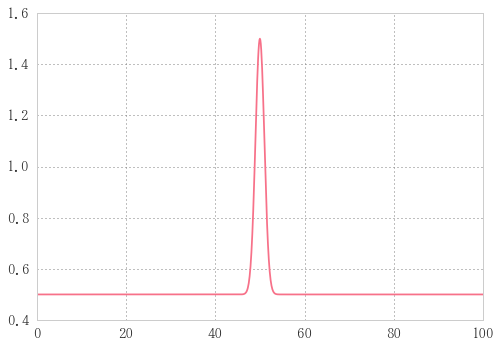

In [5]:
plt.plot(x, g)

## 自作ガウシアンじゃなくてscipy.stats.normを使うべきでは

In [34]:
from  scipy.stats import norm

In [35]:
z=norm.pdf(x, loc=50, scale=1)-0.5; z

array([-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5])

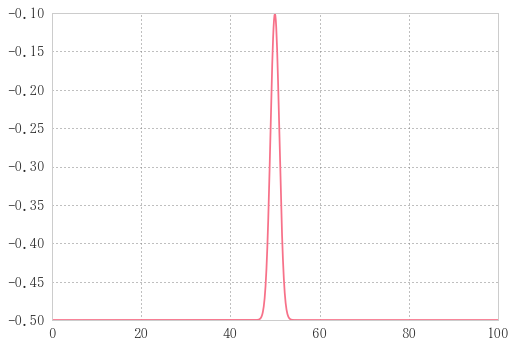

In [36]:
plt.plot(x,z)

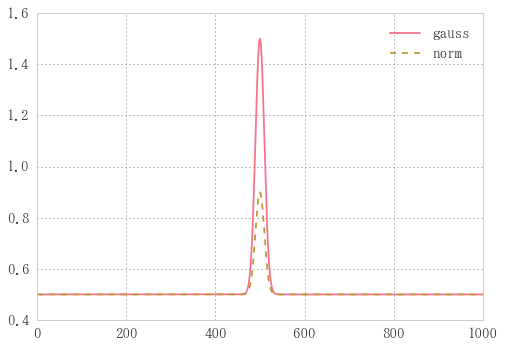

In [37]:
a, mu, si=1, 50, 1
df=pd.DataFrame({'norm': a*norm.pdf(x, loc=mu, scale=si)+nf,
                 			'gauss': gauss(x, a, mu, si, nf)})
df.plot(style=['-', '--'])

## norm vs my_gauss
normでも自作gaussでも中でnp使っているんで実行速度あんま変わらないだろうとテスト

In [38]:
%timeit gauss(x, a, mu, si)

The slowest run took 5.79 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 59.8 µs per loop


In [21]:
%timeit norm.pdf(x, loc=50, scale=1)-0.5

The slowest run took 5.26 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 218 µs per loop


自作ガウスのほうが早い…！

## ガウシアンに沿ってノイズを作る

ということで自作のガウシアンを使っていきます。

In [158]:
g = gauss(x, a, mu, si, 0.5)
gnoise = g + 0.1 * g * np.random.randn(n)

ノイズを発生させる

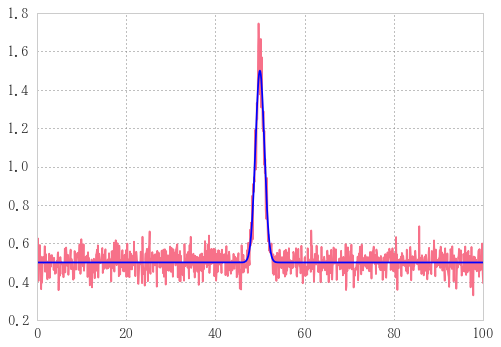

In [159]:
plt.plot(x, gnoise, '-')
plt.plot(x, g,'b-' )

## カーブフィッティングをかけて、ノイズをフィッティングする

gからgnoiseを導き出したのだけれども、ここで急にgを未知の関数とみなしてしまう。
今あなたはgnoiseだけを知っていて、gのような関数を得たいとき、どうするか。

こういう時はカーブフィットを取る。
scipy.optimizeからcurve_fitをインポートしてくる。

In [150]:
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

次にフィッティングパラメータを定める。

In [160]:
(a_, mu_, si_), _ = leastsq(gauss, x, gnoise, p0=(a, mu, si))
yfit = gauss(x, a_, mu_, si_)  # フィッティングにより導き出されたa,mu,siを代入
print('元パラメータ:%s\nフィッティングで求めたパラメータ: %s' % ((a, mu , si), (a_, mu_, si_)))

TypeError: gauss() missing 1 required positional argument: 'noisef'

In [160]:
(a_, mu_, si_), _ = curve_fit(gauss, x, gnoise, p0=(a, mu, si))
yfit = gauss(x, a_, mu_, si_)  # フィッティングにより導き出されたa,mu,siを代入
print('元パラメータ:%s\nフィッティングで求めたパラメータ: %s' % ((a, mu , si), (a_, mu_, si_)))

TypeError: gauss() missing 1 required positional argument: 'noisef'

In [46]:
_

array([[  8.87235438e-04,   4.49809686e-10,  -5.86253148e-04],
       [  4.49809686e-10,   1.16212476e-03,  -4.46876918e-10],
       [ -5.86253148e-04,  -4.46876918e-10,   1.16212476e-03]])

curve_fitの戻り値アンダーバーは共分散？

    pcov : 2d array
    The estimated covariance of popt. The diagonals provide the variance
    of the parameter estimate. To compute one standard deviation errors
    on the parameters use ``perr = np.sqrt(np.diag(pcov))``.

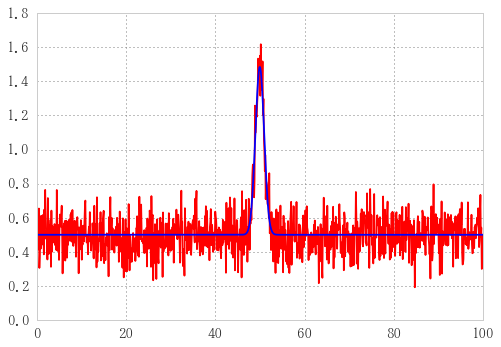

In [48]:
plt.plot(x, gnoise, 'r-')
plt.plot(x, yfit, 'b-') 

さっきと同じグラフに見えるが、描いているのはgではなくyfitであることに注意

同じグラフに見えるということはフィッティングできたということ。

# scipy.stats.normを使った場合

## ガウシアンに沿ってノイズを作る

In [19]:
from  scipy.stats import norm

In [53]:
n=1001
xx = np.linspace(0,100,n)
aa, mu, si = 5, 50, 1

In [57]:
def gauss2(x, a, mu, si):
    return a*norm.pdf(x, loc=mu, scale=si)-noisef

In [58]:
g = gauss2(xx, aa, mu, si)
gnoise = g + 0.1 * np.random.randn(n)

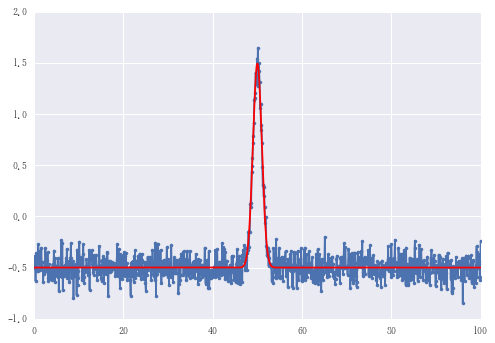

In [59]:
plt.plot(xx, gnoise, '.-')
plt.plot(xx, g,'r-' )

## カーブフィッティングをかけて、ノイズをフィッティングする

gからgnoiseを導き出したのだけれども、ここで急にgを未知の関数とみなしてしまう。
今あなたはgnoiseだけを知っていて、gのような関数を得たいとき、どうするか。

In [66]:
from scipy.optimize import curve_fit
(aa_, mu_, si_), _ = curve_fit(gauss2, xx, gnoise, (aa, mu, si))
yfit = gauss2(xx,aa_, mu_, si_)

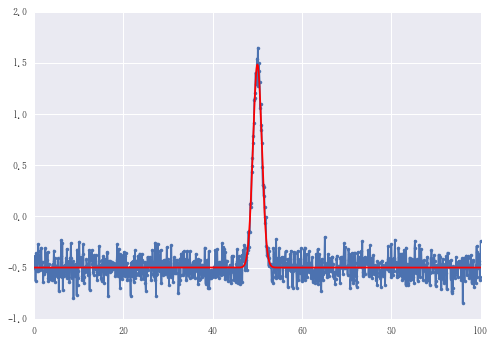

In [67]:
plt.plot(xx, gnoise, '.-')
plt.plot(xx, yfit, 'r-')  # 描いているのはgではなく、yfitであることに注意

ちゃんとフィッティングできた。

# 自作ガウスをノイズのあるデータフレームにcarve_fitをapply

## ランダムデータフレームの作成

In [6]:
r=np.random

いっぱい使うから乱数生成をrに縮めちゃう

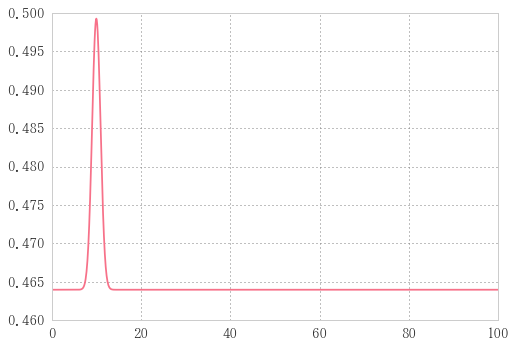

In [7]:
g = gauss(x, a=r.rand(), mu=10*1, si=10*r.rand(), noisef=nf*r.rand())
plt.plot(x, g)

ランダムな値を使って発生させたガウシアン

In [8]:
%%timeit
df = pd.DataFrame([], index=range(1000))
for i in np.arange(min(x), max(x), 10):
    g = gauss(x, a=r.rand(), mu=i, si=10*r.rand(), noisef=nf)
    df[i] = pd.DataFrame(g)

100 loops, best of 3: 8.69 ms per loop


まず思いつくforループ

In [12]:
%%timeit
garray = np.array([gauss(x, a=r.rand(), mu=i, si=10*r.rand(), noisef=nf)
                    for i in np.arange(min(x), max(x), 10)]).T
df = pd.DataFrame(garray)

1000 loops, best of 3: 743 µs per loop


リスト内包表記を使うことでより高速

In [81]:
%%timeit
xa = np.tile(x, (10,1))
aa = abs(r.randn(10))
mua = np.arange(min(x), max(x), 10)
sia = 10 * abs(r.randn(10))

df = pd.DataFrame(gauss(xa.T, aa, mua, sia, nf))

1000 loops, best of 3: 693 µs per loop


np.arrayで変数作るともっともっと高速

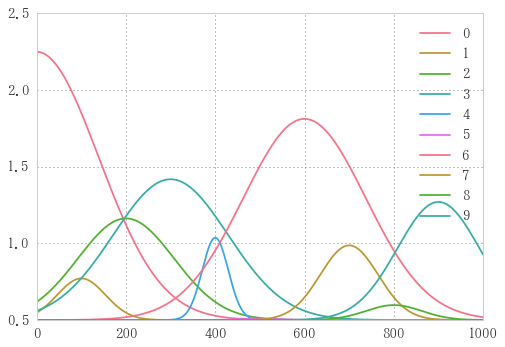

In [82]:
gdf.plot()

## 足し合わせた複数の波があるdf

様々な形のガウシアン。

ノイズフロアは一定にした。

こいつらにノイズを載せる。

## ランダムデータフレームにノイズのせてサンプルデータ作成

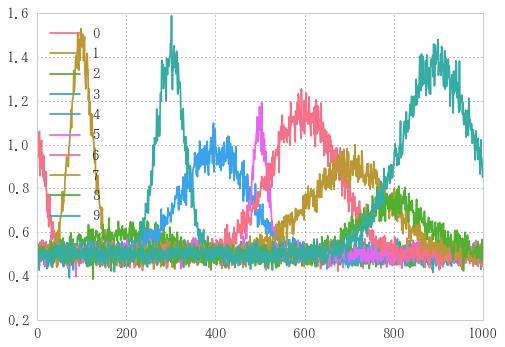

In [89]:
noisedf =df + df * 0.05 * r.randn(*df.shape)
noisedf.plot()

5%のノイズをのせた。
`np.randn(*df.shape)`でデータフレームと同じ行列を持ったランダムデータフレームを生成させている。
スターを`df.shape`の前につけてタプルを展開して`randn`に渡す。

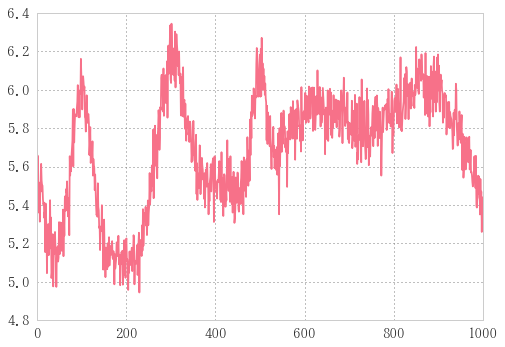

In [90]:
sumdf = noisedf.sum(axis=1)
sumdf.plot()

In [85]:
sumdf

0       5.432676
1       5.605698
2       5.298539
3       5.522210
4       5.598536
5       5.628876
6       5.590488
7       5.520159
8       5.357040
9       5.524325
10      5.352305
11      5.252700
12      5.442083
13      5.357631
14      5.633205
15      5.394023
16      5.485547
17      5.300434
18      5.472389
19      5.403377
20      4.983068
21      5.330210
22      5.274541
23      5.166913
24      5.551668
25      5.476331
26      5.108893
27      4.984221
28      5.214877
29      5.402299
          ...   
971     5.363341
972     5.478791
973     5.665920
974     5.777761
975     5.737976
976     5.659097
977     5.625246
978     5.545209
979     5.726983
980     5.747878
981     5.479815
982     5.714544
983     5.406541
984     5.325538
985     5.532115
986     5.222370
987     5.502674
988     5.481744
989     5.548988
990     5.690841
991     5.502521
992     5.599736
993     5.366537
994     5.508551
995     5.497639
996     5.128502
997     5.403535
998     5.3501

indexはそのままにカラムをすべて足す。この中でindexいくつの位置にガウシアンが立つかを調べる。

## 複数のランダムウェーブを生成

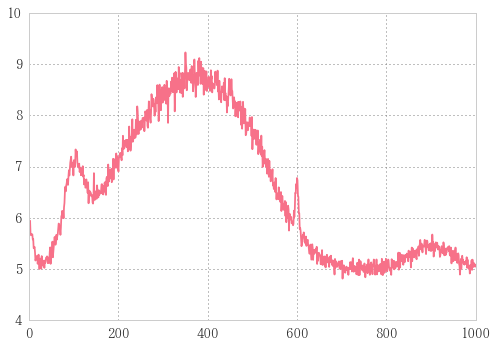

In [133]:
def waves(seed: int=np.random.randint(100)):
    """ランダムノイズを発生させたウェーブを作成する
    引数: seed: ランダムステートを初期化する整数。デフォルトでseedをランダムに発生させる
    戻り値: noisedf.sum(1): pd.Series型"""
    r = np.random
    r.seed(seed)  # ランダム初期化
    xa = np.tile(x, (10,1))
    aa = abs(r.randn(10))
    mua = np.arange(min(x), max(x), 10)
    sia = 10 * abs(r.randn(10))

    df = pd.DataFrame(gauss(xa.T, aa, mua, sia, nf))
    noisedf = df + df * 0.05 * r.randn(*df.shape)
    return noisedf.sum(1)
waves().plot()

In [147]:
%timeit waves()

100 loops, best of 3: 2.33 ms per loop


In [148]:
df = pd.DataFrame([waves(i) for i in range(10)]); df

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,6.945187,7.108197,6.845565,6.948541,6.845199,7.055347,6.977616,7.056927,7.079365,7.138362,...,5.352165,5.237588,5.368697,5.147199,5.197124,5.213663,5.317618,5.263670,5.266836,5.319199
1,7.133442,7.059512,7.190294,7.232617,7.261932,7.016845,7.189088,7.295845,7.185489,7.022073,...,5.166897,5.017208,5.075220,5.214620,5.136346,5.049252,5.014033,5.049660,5.022505,5.217068
2,5.348248,5.553449,5.548598,5.538164,5.430301,5.412686,5.579073,5.552572,5.647116,5.415833,...,5.104680,5.207193,5.014641,5.061536,5.125885,5.072221,5.181555,4.908350,5.057412,5.102178
3,7.274488,7.426611,7.076638,7.595002,7.723684,7.506426,7.210183,7.406186,7.584276,7.486866,...,5.332370,5.272767,5.421780,5.499642,5.210076,5.363444,5.385211,5.220253,5.466960,5.286162
4,5.086649,5.070892,5.054293,5.011917,5.164769,5.146161,4.921866,5.057269,5.123093,5.084757,...,5.065826,5.150936,5.078083,5.028696,5.064742,5.037380,5.331177,5.131369,5.206482,5.235898
5,5.380750,5.546886,5.502097,5.557626,5.416009,5.364240,5.585252,5.475956,5.528495,5.392496,...,5.354433,5.439949,5.550969,5.281462,5.491426,5.382127,5.453180,5.208387,5.277590,5.423068
6,5.629440,5.443759,5.531657,5.720805,5.500641,5.665483,5.582582,5.677595,5.435612,5.648220,...,5.288703,5.109035,5.229636,5.267676,5.134689,5.277698,5.236259,5.066652,5.206823,5.181833
7,6.827328,6.582126,6.744212,6.905696,6.514176,6.890059,6.824137,6.794166,6.634765,6.680948,...,5.532310,5.495926,5.500994,5.431254,5.448915,5.520323,5.463009,5.670345,5.523788,5.370447
8,6.417707,6.429011,6.475284,6.290368,6.670582,6.636257,6.427363,6.455692,6.620168,6.508548,...,4.998059,4.907901,4.900991,4.984814,5.011483,4.939173,5.053548,4.868739,4.874232,4.905128
9,5.285603,5.404935,5.279550,5.060339,5.276347,5.236848,5.305694,5.347108,5.337980,5.361805,...,5.626433,5.572625,5.647371,5.480810,5.495603,5.535284,5.492852,5.550408,5.592165,5.344825


# データフレームに一斉にフィッティングかける
一番やりたかったこと　ここから。

In [242]:
param = (a, mu, si) = 5, 300, 3
param

(5, 300, 3)

パラメータ再設定

## 試しに波を一つ選んでfitting

In [254]:
def choice(array, center, span):
    """特定の範囲を抜き出す
    引数: 
        array: 抜き出し対象のarrayっぽいの(arraylike)
        center: 抜き出し中央(float)
        span: 抜き出しスパン(float)
    戻り値:
        rarray:
    """
    x1 = int(center - span / 2)
    x2 = int(center + span / 2)
    return array[x1:x2]

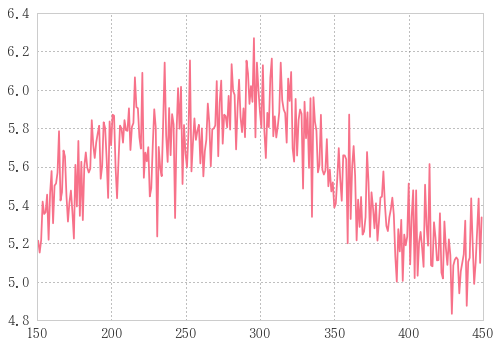

In [256]:
ch = (300, 300)  # 中央値300でスパン300で取り出したい
fitx, fity = choice(sumdf.index, *ch), choice(sumdf, *ch)
plt.plot(fitx, fity)

In [275]:
popt, _pcov = curve_fit(gauss, fitx, fity, p0=param)
print('a, mu, si = ', popt)

a, mu, si =  [   5.33304014  272.51733965  288.27265293]


fittingの結果

In [274]:
gg = gauss(sumdf.index,*popt)

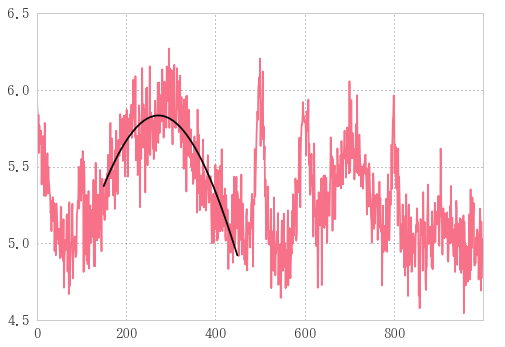

In [273]:
sumdf.plot()
plt.plot(fitx, choice(gg, *ch), 'k-')

fittingの結果を用いてガウシアン描いてみる。

## 連続的にfitting

In [303]:
fitting_list = (300, 500, 600, 700)  # 目測どのあたりに波があるか
fitdf=pd.DataFrame(np.empty(1000))
for i in fitting_list:
    param = (a, mu, si) = 5, i, 3
    ch = (i, 300)
    fitx, fity = choice(sumdf.index, *ch), choice(sumdf, *ch)
    popt, _pcov = curve_fit(gauss, fitx, fity, p0=param, maxfev = 10000)
    gg = gauss(sumdf.index,*popt)
    fitdf[i] = pd.DataFrame(choice(gg, *ch), index=fitx)
del fitdf[0]

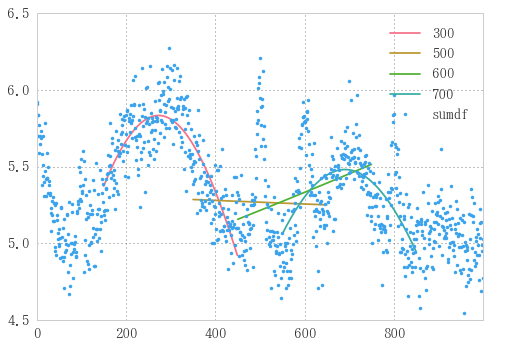

In [323]:
fitdf['sumdf'] = sumdf
fitdf.plot(style = ['-', '-', '-', '-', '.'])

In [152]:
fit=lambda df: curve_fit(gauss, x[:-1], df['0.0'], p0=(a, mu, si))

In [231]:
sumdf.apply(fit)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [211]:
Bfit = noisedf.T
Bfit.index=pd.date_range('20161111', freq='H', periods=10)
Bfit

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2016-11-11 00:00:00,1.212010,1.258258,1.209776,1.288453,1.312047,1.208359,1.235260,1.076348,1.234967,1.137405,...,0.514774,0.428211,0.598484,0.522549,0.519271,0.520157,0.412700,0.448095,0.461003,0.485658
2016-11-11 01:00:00,0.493312,0.565844,0.421950,0.566338,0.429704,0.490249,0.477613,0.543168,0.509640,0.466321,...,0.429264,0.449661,0.472302,0.450089,0.532711,0.497850,0.444576,0.510375,0.542243,0.559332
2016-11-11 02:00:00,0.617668,0.504491,0.506655,0.629424,0.459623,0.550356,0.552120,0.517778,0.474713,0.492209,...,0.459309,0.579805,0.506900,0.461104,0.452450,0.535329,0.465263,0.535872,0.549523,0.442362
2016-11-11 03:00:00,0.534732,0.434818,0.452569,0.429995,0.550611,0.552787,0.470041,0.503814,0.536437,0.526805,...,0.507729,0.510552,0.523317,0.480549,0.537138,0.477658,0.510539,0.461372,0.454722,0.471645
2016-11-11 04:00:00,0.410273,0.480496,0.535665,0.476028,0.496251,0.497739,0.532563,0.579697,0.466402,0.458867,...,0.452442,0.539615,0.476664,0.465095,0.469500,0.567530,0.465824,0.543424,0.524870,0.597768
2016-11-11 05:00:00,0.504844,0.585218,0.436708,0.510879,0.534301,0.533283,0.486974,0.505978,0.457899,0.416528,...,0.512470,0.516137,0.471788,0.485482,0.477160,0.424786,0.461915,0.421985,0.521713,0.534520
2016-11-11 06:00:00,0.417943,0.510378,0.561102,0.473348,0.547520,0.501062,0.538977,0.506837,0.576644,0.429382,...,0.538923,0.543066,0.634124,0.437527,0.546653,0.428585,0.503116,0.488980,0.513469,0.465994
2016-11-11 07:00:00,0.456581,0.578147,0.534539,0.437597,0.494838,0.445275,0.459347,0.466767,0.550208,0.408358,...,0.596552,0.572876,0.421376,0.626990,0.540775,0.502943,0.534820,0.420050,0.515703,0.511490
2016-11-11 08:00:00,0.487674,0.527124,0.462124,0.519189,0.478155,0.535298,0.458398,0.579006,0.470864,0.533235,...,0.572156,0.622233,0.477770,0.568988,0.541956,0.573163,0.493426,0.543387,0.540880,0.535761
2016-11-11 09:00:00,0.499399,0.443160,0.370964,0.410643,0.460746,0.571716,0.487904,0.524689,0.585601,0.635540,...,0.421390,0.476703,0.492336,0.474076,0.417654,0.580822,0.522962,0.434270,0.505289,0.437671


実際fittingかけたいデータフレームはindexが時間、カラムが

___

In [2]:
import sys
sys.path.append('../')

In [4]:
from fitclass import *

In [5]:
# giving initial parameters
mu = Parameter(7)
sigma = Parameter(3)
height = Parameter(5)

In [13]:
# define your function:
def f(x, h=height(), mu=mu(), si=sigma()): return h * np.exp(-((x-mu)/si)**2)

In [16]:
# fit! (given that data is an array with the data to fit)
data = 10*np.exp(-np.linspace(0, 10, 100)**2) + np.random.rand(100)
fitp, _ = fit(f, [mu, sigma, height], data); fitp

array([ -1.89549379,  12.09140583,  11.17214325])

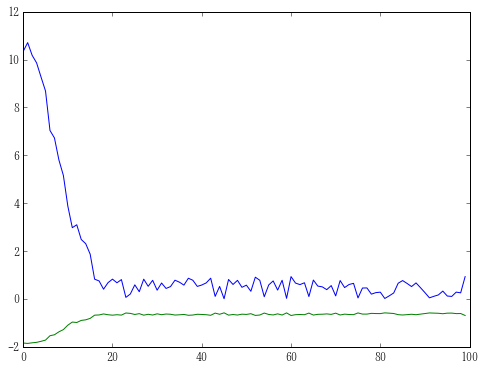

In [21]:
plt.plot(data)
plt.plot(f(data, *fitp))